In [2]:
import sys

sys.path.append("../src/")
from Intensity_PDF import *
from Tissue_Fluorophore import Tissue_Fluorophore
from irf_function import IRF
from spectral_sensitivity import SpectralSensitivity
from bias import Bias
import numpy as np
from typing import Tuple
from visualisation_utils import (
    save_data,
    save_peak_intensities,
    save_bias_data,
    plot_peak_intensity_per_channel,
    data_and_irf_inspection,
    single_data_and_irf_inspection,
    get_max_and_average_peak_intensity_per_channel,
    get_peak_intensity_per_channel,
)
from scipy import signal
from scipy import interpolate as interp
from scipy.integrate import quad
import seaborn as sns
from path_vars import IRF_PATH, PDE_PATH


sns.set_style("whitegrid")

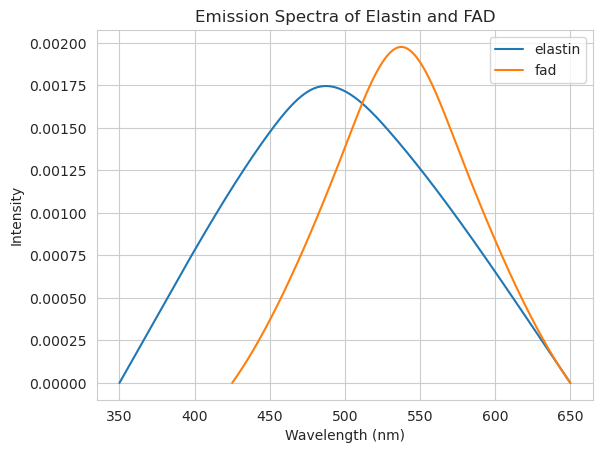

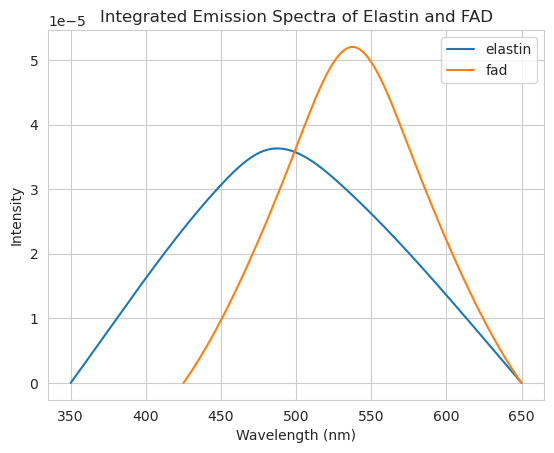

Max Elastin y: 0.0017458498510225084
Max FAD y: 0.0019758183681737357
Max Integrated Elastin y: 3.6296172895514237e-05
Max Integrated FAD y: 5.200975607280627e-05


In [81]:
distribution_locations = "../data/endogenous-fluoro-emissions"
# loading elastin and fad splines (riboflavin is same emission as fad for now)
elastin_spline_info = np.load(
    f"{distribution_locations}/left_shifted_elastin_spline.npz"
)
elastin_bounds = Wavebounds(
    np.min(elastin_spline_info["x"]), np.max(elastin_spline_info["x"])
)
elastin_spline = interp.UnivariateSpline(
    elastin_spline_info["x"], elastin_spline_info["y"], s=elastin_spline_info["s"]
)

fad_spline_info = np.load(f"{distribution_locations}/fad_spline.npz")
fad_bounds = Wavebounds(np.min(fad_spline_info["x"]), np.max(fad_spline_info["x"]))
fad_spline = interp.UnivariateSpline(
    fad_spline_info["x"], fad_spline_info["y"], s=fad_spline_info["s"]
)

# plot the splines
elastin_x = np.linspace(*elastin_bounds, 1000)
elastin_y = elastin_spline(elastin_x)
elastin_y /= np.sum(elastin_y)
integrated_elastin_factor = quad(elastin_spline, *elastin_bounds)[0]
integrated_elastin_y = elastin_y / integrated_elastin_factor

fad_x = np.linspace(*fad_bounds, 1000)
fad_y = fad_spline(fad_x)
fad_y /= np.sum(fad_y)
integrated_fad_factor = quad(fad_spline, *fad_bounds)[0]
integrated_fad_y = fad_y / integrated_fad_factor


plt.figure()
sns.lineplot(x=elastin_x, y=elastin_y, label="elastin")
sns.lineplot(x=fad_x, y=fad_y, label="fad")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Emission Spectra of Elastin and FAD")
plt.legend()
plt.show()

plt.figure()
sns.lineplot(x=elastin_x, y=elastin_y / integrated_elastin_factor, label="elastin")
sns.lineplot(x=fad_x, y=fad_y / integrated_fad_factor, label="fad")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Integrated Emission Spectra of Elastin and FAD")
plt.legend()
plt.show()

print(f"Max Elastin y: {np.max(elastin_y)}")
print(f"Max FAD y: {np.max(fad_y)}")

max_integrated_elastin_y = np.max(integrated_elastin_y)
max_integrated_fad_y = np.max(integrated_fad_y)
print(f"Max Integrated Elastin y: {np.max(integrated_elastin_y)}")
print(f"Max Integrated FAD y: {np.max(integrated_fad_y)}")

In [82]:
N = 11_600_000 * max_integrated_elastin_y  # Total number of samples
tau = 0.5  # Scale parameter of the exponential distribution
bin_width = 0.51  # Bin width in ns

# Define bin edges
emission_edges = np.arange(300, 900, 0.5)
bin_edges = np.arange(0, 60, bin_width)
expected_counts = []
for i in range(len(emission_edges) - 1):
    a = emission_edges[i]
    b = emission_edges[i + 1]
    # Integral of the exponential PDF over [a, b]
    integral = quad(elastin_spline, b, a)[0]
    expected_count = N * integral
    expected_counts.append(expected_count)

print(f"Expected counts: {np.max(expected_counts)}")

N = np.max(expected_counts)  # Total number of samples

# Calculate expected counts in each bin
expected_counts = []
for i in range(len(bin_edges) - 1):
    a = bin_edges[i]
    b = bin_edges[i + 1]
    # Integral of the exponential PDF over [a, b]
    integral = (1 / tau) * (np.exp(-a / tau) - np.exp(-b / tau))
    expected_count = N * integral
    expected_counts.append(expected_count)

# Find the bin with the maximum expected count
peak_bin_index = np.argmax(expected_counts)
peak_count = expected_counts[peak_bin_index]
peak_bin = (bin_edges[peak_bin_index], bin_edges[peak_bin_index + 1])

print(f"Peak bin: {peak_bin}, Expected count: {peak_count}")

Expected counts: 56.429296579506904
Peak bin: (0.0, 0.51), Expected count: 72.16235551082143


In [109]:
N = np.max(elastin_y) * 4_000_000
# ceil N to the nearest 1000
N = int(np.ceil(N / 1000) * 1000)
print(f"N: {N}")

N: 7000


Max of y: 0.03342849536249334
Peak counts: 280.80


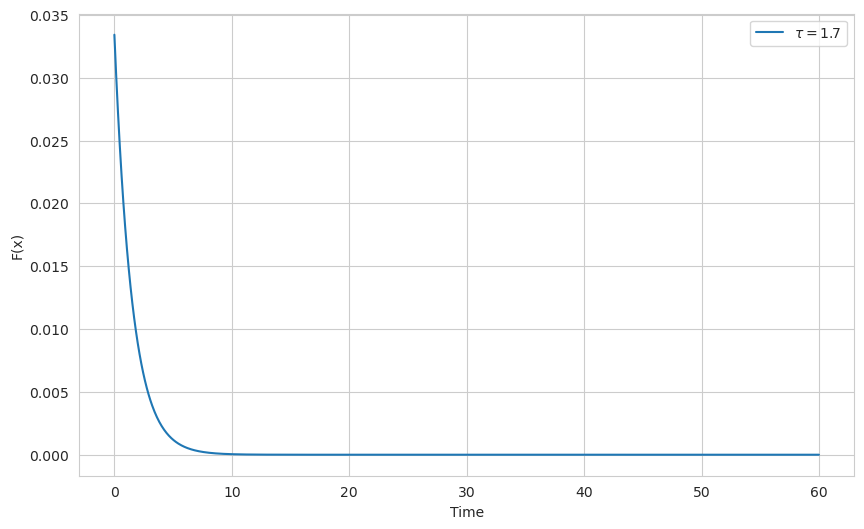

In [110]:
num_photons = N * 1.2
# F(x) = 1 - e^(-x / \tau)
tau = 1.5

# f = lambda x, tau: 1 - np.exp(-x / tau)
f = lambda x, tau: np.exp(-x / tau)
x = np.arange(0, 60, 0.051)
y = f(x, tau)
y /= np.sum(y)

# y /=( np.sum(y) / ( tau))
# y /= (interal_y)


print(f"Max of y: {np.max(y)}")
print("Peak counts: {:.2f}".format(num_photons * np.max(y)))
# y = y * num_photons * emission_highest_probability
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=r"$\tau = 1.7$")
plt.xlabel("Time")
plt.ylabel("F(x)")
plt.legend()
plt.show()

In [72]:
N

9038.463760524242